In [2]:
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import itertools
import numpy as np
import random
import pandas as pd
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D,Flatten,Dense, Dropout, BatchNormalization, Add, AveragePooling3D, Activation, GaussianNoise, Lambda
from tensorflow.keras import optimizers, losses, regularizers
from tensorflow.keras.initializers import glorot_normal
from tensorflow.keras.utils import plot_model, Sequence
from tensorflow.keras.activations import relu
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import Adam, SGD
from IPython.display import SVG
from sklearn.metrics import confusion_matrix, matthews_corrcoef
from tqdm import tqdm, trange
import tensorflow as tf
import os

# Read Data

In [3]:
def create_optimizer(args, optim_params):
    if args.optimizer == 'sgd':
        return optim.SGD(optim_params, args.lr, momentum=args.momentum,
                         weight_decay=args.weight_decay)
    elif args.optimizer == 'adagrad':
        return optim.Adagrad(optim_params, args.lr, weight_decay=args.weight_decay)
    elif args.optimizer == 'adam':
        return optim.Adam(optim_params, args.lr, betas=(args.beta1, args.beta2),
                          weight_decay=args.weight_decay)
    elif args.optimizer == 'amsgrad':
        return optim.Adam(optim_params, args.lr, betas=(args.beta1, args.beta2),
                          weight_decay=args.weight_decay, amsgrad=True)
    elif args.optimizer == 'adabound':
        from adabound import AdaBound
        return AdaBound(optim_params, args.lr, betas=(args.beta1, args.beta2),
                        final_lr=args.final_lr, gamma=args.gamma,
                        weight_decay=args.weight_decay)
    else:
        assert args.optimizer == 'amsbound'
        from adabound import AdaBound
        return AdaBound(optim_params, args.lr, betas=(args.beta1, args.beta2),
                        final_lr=args.final_lr, gamma=args.gamma, 
                        weight_decay=args.weight_decay, amsbound=True) 

In [4]:
# Reads a up to spec pdb file and return a tuple of the
# atoms' x, y, z and atomtype
def read_pdb(filename):
    with open(filename, 'r') as file:
        strline_L = file.readlines()
    atom_list = []
    for strline in strline_L:
        # removes all whitespace at the start and end, including spaces, tabs, newlines and carriage returns
        stripped_line = strline.strip()

        line_length = len(stripped_line)
        # print("Line length:{}".format(line_length))
        if line_length < 78:
            print("ERROR: line length is different. Expected>=78, current={}".format(line_length))
        
        atom_list.append((
            stripped_line[30:38].strip(),
            stripped_line[38:46].strip(),
            stripped_line[46:54].strip(),
            'h' if stripped_line[76:78].strip() == 'C' else 'p',
        ))
        
    return np.array(atom_list, order='F')

In [5]:
# Reads the test pdb file and return a top of the 10
# atoms' x, y, z and atomtype
def read_test_pdb(filename):
    with open(filename, 'r') as file:
        strline_L = file.readlines()
    atom_list = []
    for strline in strline_L:
        # removes all whitespace at the start and end, including spaces, tabs, newlines and carriage returns
        stripped_line = strline.strip()
        tokens = stripped_line.split("\t")
        
        atom_list.append((
            tokens[0],
            tokens[1],
            tokens[2],
            tokens[3],
        ))

    return np.array(atom_list, order='F')

In [6]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('practical')
    plt.xlabel('Predictive')
    plt.tight_layout()

In [7]:
def mcc(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

def ppv(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = tp
    denominator = tp + fp

    return numerator / (denominator + K.epsilon())

def tpr(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = tp
    denominator = tp + fn

    return numerator / (denominator + K.epsilon())


# Pro-processing

In [8]:
training_data = {
    'protein': [],
    'ligand': []
}
for i in trange(3000):
    training_data['protein'].append(
        read_pdb("training_data/{:04d}_pro_cg.pdb".format(i + 1)))
    training_data['ligand'].append(
        read_pdb("training_data/{:04d}_lig_cg.pdb".format(i + 1)))

100%|██████████| 3000/3000 [00:07<00:00, 389.67it/s]


In [9]:
n = int(len(training_data['protein'])*0.9)

In [10]:
train_data = {
    'pro': training_data['protein'][:n],
    'lig': training_data['ligand'][:n]
}
test_data = {
    'pro': training_data['protein'][n:],
    'lig': training_data['ligand'][n:]
}

In [11]:
from sparse import COO
import sparse

/mistgpu/site-packages/numba/core/errors.py:154: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [12]:
# Returns a sparse matrix representation of the voxel
def voxelize(pdb_inputs, max_dist=20, grid_resolution=4):
    def featurize(atom_type):
        # Default: protein, hydrophobic
        feat = [0, 128]
        # Change to ligand
        if atom_type[1] == 'l':
            feat[0] = 1
        # change to polar
        if atom_type[0] == 'p':
            feat[1] = 256
        return feat
    
    max_dist = float(max_dist)
    grid_resolution = float(grid_resolution)
    box_size = np.ceil(2 * max_dist / grid_resolution + 1)

    # merge protein and ligand
    pro_atoms = pdb_inputs[0]
    lig_atoms = pdb_inputs[1]
    pro_atoms = np.c_[pro_atoms, np.full(pro_atoms.shape[0], 'p')]
    lig_atoms = np.c_[lig_atoms, np.full(lig_atoms.shape[0], 'l')]
    all_atoms = np.r_[pro_atoms, lig_atoms]

    # center all atoms around the center of the protein
    coord_mat = all_atoms[:,:3].astype(np.float)
    coord_mat = coord_mat - np.mean(lig_atoms[:,:3].astype(np.float), axis=0)

    # add feature list to identify the atom h/p and pro/lig
    feats_list = np.asarray([featurize(atom_type) for atom_type in all_atoms[:,-2:]])  
    atom_mat = np.c_[coord_mat, feats_list]

    # move all atoms to the nearest grid point
    atom_mat = np.c_[coord_mat, feats_list]
    atom_mat[:,:3] = (atom_mat[:,:3] + max_dist) / grid_resolution
    atom_mat[:,:3] = atom_mat[:,:3].round()
    atom_mat = atom_mat.astype(int)

    # remove atoms outside the box
    in_box = ((atom_mat[:,:3] >= 0) & (atom_mat[:,:3] < box_size)).all(axis=1)
    atom_mat = atom_mat[in_box]

    # transpose the matrix
    feats_list = np.squeeze(atom_mat[:,-1:])
    atom_mat = atom_mat[:,:4].T
    
    # create the sparse matrix
    s = COO(atom_mat, feats_list, shape=(int(box_size), int(box_size), int(box_size), 2))
    s.sum()
    s = s.reshape((1, int(box_size), int(box_size), int(box_size), 2))
    
    return s

In [13]:
# Returns a tuple containg the training data and corresponding labels
# ratio specifies the number of negative training examples generated
# per positive training example
def generate_training_data(raw_data, pos_ratio=1, neg_ratio=1, max_dist=20, grid_resolution=4, quiet=False):
    n = len(raw_data['pro'])
    x_all = []
    y_all = []
    for i in tqdm(range(n), disable=quiet):
        for _ in range(pos_ratio):
            grid = voxelize((
                raw_data['pro'][i],
                raw_data['lig'][i]
            ), max_dist, grid_resolution)
            x_all.append(grid)
            y_all.append([1.])
        for _ in range(neg_ratio):
            grid = voxelize((
                raw_data['pro'][i],
                raw_data['lig'][random.choice(list(range(i)) + list(range(i+1, n)))]
            ), max_dist, grid_resolution)
            x_all.append(grid)
            y_all.append([0.])
    return sparse.concatenate(x_all), np.asarray(y_all)

In [14]:
class ProLigSequence(Sequence):

    def __init__(self, raw_data, max_dist=20, grid_resolution=4, batch_size=128, neg_ratio=1, quiet=True, sparse=True):
        self.raw_data = raw_data
        self.max_dist = max_dist
        self.grid_resolution = grid_resolution
        self.batch_size = batch_size
        self.neg_ratio = neg_ratio
        self.quiet = quiet
        self.sparse = sparse
        self.pos_eg_x, self.pos_eg_y = generate_training_data(raw_data, neg_ratio=0, max_dist=max_dist, grid_resolution=grid_resolution, quiet=self.quiet)
        if not sparse:
            self.pos_eg_x = self.pos_eg_x.todense()
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.ceil(len(self.all_eg_x) / float(self.batch_size)))

    def __getitem__(self, idx):
        indexes = self.indexes[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_x = self.all_eg_x[indexes].todense() if self.sparse else self.all_eg_x[indexes]
        batch_y = self.all_eg_y[indexes]
        return batch_x, batch_y

    def on_epoch_end(self):
        # Generate a new set of negative training examples
        self.neg_eg_x, self.neg_eg_y = generate_training_data(
            self.raw_data,
            pos_ratio=0,
            neg_ratio=self.neg_ratio,
            max_dist=self.max_dist,
            grid_resolution=self.grid_resolution,
            quiet=self.quiet
        )
        if self.sparse:
            self.all_eg_x = sparse.concatenate((self.pos_eg_x, self.neg_eg_x))
        else:
            self.all_eg_x = np.concatenate((self.pos_eg_x, self.neg_eg_x.todense()))
        self.all_eg_y = np.concatenate((self.pos_eg_y, self.neg_eg_y))
        self.indexes = np.arange(len(self.all_eg_x))
        np.random.shuffle(self.indexes)

# Build Wide ResNet Model

In [15]:
# k defines the width of the network as defined in the Wide ResNet paper
def generate_resnet(input_shape, k=1, noise=False,
                    l1_filters=16, l1_kernel_size=3, l1_dilation_rate=1):
    inputs = Input(shape=input_shape)
    x = inputs
    x = Conv3D(
        filters=l1_filters,
        kernel_size=l1_kernel_size,
        dilation_rate=l1_dilation_rate,
        padding='valid',
        data_format='channels_last',
        kernel_initializer='he_normal',
    )(x)
    
    # Block 1.1 32 Features
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x2 = Conv3D(
        filters=32*k,
        kernel_size=1,
        padding='same',
        data_format='channels_last',
        kernel_initializer='he_normal',
    )(x)
    x1 = Conv3D(
        filters=32*k,
        kernel_size=3,
        padding='same',
        data_format='channels_last',
        kernel_initializer='he_normal',
    )(x)
    x1 = Dropout(0.5)(x1)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x1 = Conv3D(
        filters=32*k,
        kernel_size=3,
        padding='same',
        data_format='channels_last',
        kernel_initializer='he_normal',
    )(x1)
    x = Add()([x1, x2])

    # Block 1.2 32 Features
    x2 = x
    x1 = BatchNormalization()(x)
    x1 = Activation('relu')(x1)
    x1 = Conv3D(
        filters=32*k,
        kernel_size=3,
        padding='same',
        data_format='channels_last',
        kernel_initializer='he_normal',
    )(x1)
    x1 = Dropout(0.5)(x1)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x1 = Conv3D(
        filters=32*k,
        kernel_size=3,
        padding='same',
        data_format='channels_last',
        kernel_initializer='he_normal',
    )(x1)
    x = Add()([x1, x2])

    # Block 2.1 64 Features
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x2 = Conv3D(
        filters=64*k,
        kernel_size=1,
        padding='same',
        data_format='channels_last',
        kernel_initializer='he_normal',
    )(x)
    x1 = Conv3D(
        filters=64*k,
        kernel_size=3,
        padding='same',
        data_format='channels_last',
        kernel_initializer='he_normal',
    )(x)
    x1 = Dropout(0.5)(x1)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x1 = Conv3D(
        filters=64*k,
        kernel_size=3,
        padding='same',
        data_format='channels_last',
        kernel_initializer='he_normal',
    )(x1)
    x = Add()([x1, x2])

    # Block 2.2 64 Features
    x2 = x
    x1 = BatchNormalization()(x)
    x1 = Activation('relu')(x1)
    x1 = Conv3D(
        filters=64*k,
        kernel_size=3,
        padding='same',
        data_format='channels_last',
        kernel_initializer='he_normal',
    )(x1)
    x1 = Dropout(0.5)(x1)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x1 = Conv3D(
        filters=64*k,
        kernel_size=3,
        padding='same',
        data_format='channels_last',
        kernel_initializer='he_normal',
    )(x1)
    x = Add()([x1, x2])    
    
    # Block 3.1 128 Features
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x2 = Conv3D(
        filters=128*k,
        kernel_size=1,
        padding='same',
        data_format='channels_last',
        kernel_initializer='he_normal',
    )(x)
    x1 = Conv3D(
        filters=128*k,
        kernel_size=3,
        padding='same',
        data_format='channels_last',
        kernel_initializer='he_normal',
    )(x)
    x1 = Dropout(0.5)(x1)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x1 = Conv3D(
        filters=128*k,
        kernel_size=3,
        padding='same',
        data_format='channels_last',
        kernel_initializer='he_normal',
    )(x1)
    x = Add()([x1, x2])

    # Block 3.2 128 Features
    x2 = x
    x1 = BatchNormalization()(x)
    x1 = Activation('relu')(x1)
    x1 = Conv3D(
        filters=128*k,
        kernel_size=3,
        padding='same',
        data_format='channels_last',
        kernel_initializer='he_normal',
    )(x1)
    x1 = Dropout(0.5)(x1)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x1 = Conv3D(
        filters=128*k,
        kernel_size=3,
        padding='same',
        data_format='channels_last',
        kernel_initializer='he_normal',
    )(x1)
    x = Add()([x1, x2])      
    
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = AveragePooling3D()(x)
    x = Flatten()(x)
    x = Dense(
        128,
        activation='relu',
        kernel_initializer='he_normal',
    )(x)
    x = Dropout(0.5)(x)
    outputs = Dense(
        1,
        activation='sigmoid',
        kernel_initializer='he_normal',
    )(x)

    return Model(inputs=inputs, outputs=outputs)


In [16]:
model = generate_resnet(
    input_shape=(21, 21, 21, 2),
    k=1,
    l1_filters=16,
    l1_kernel_size=6,
    l1_dilation_rate=3,
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 21, 21, 21,  0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 6, 6, 6, 16)  6928        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 6, 6, 6, 16)  64          conv3d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 6, 6, 6, 16)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

# Adaboost Optimizer

In [17]:
from keras_adabound import AdaBound
model.compile(loss='binary_crossentropy',metrics=['acc', mcc, ppv, tpr],optimizer=Adam())

In [33]:
model.compile(optimizer=AdaBound(lr=1e-3, final_lr=0.1), loss='binary_crossentropy',metrics=['acc', mcc, ppv, tpr])

In [18]:
training_model = model.fit_generator(
    generator=ProLigSequence(train_data, batch_size=512, max_dist=40, grid_resolution=4, sparse=False),
    validation_data=ProLigSequence(test_data, batch_size=512, max_dist=40, grid_resolution=4, sparse=False),
    epochs=30,
    initial_epoch=0,
    use_multiprocessing=True,
    workers=8,
    callbacks=[ModelCheckpoint('model.h5',
                           monitor='val_mcc',
                           verbose=1,
                           save_best_only=True,
                           mode='max',
                           period=1),
              TensorBoard()]
)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.6/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/30
11/11 [==============================] - 20s 1s/step - loss: 0.6641 - acc: 0.7485 - mcc: 0.5117 - ppv: 0.7987 - tpr: 0.6973 - val_loss: 63.5683 - val_acc: 0.5017 - val_mcc: 0.0224 - val_ppv: 0.4864 - val_tpr: 1.0000

Epoch 00001: val_mcc improved from -inf to 0.02238, saving model to model.h5
Epoch 2/30
11/11 [==============================] - 9s 665ms/step - loss: 0.2308 - acc: 0.9283 - mcc: 0.8604 - ppv: 0.8911 - tpr: 0.9751 - val_loss: 139.8711 - val_acc: 0.5300 - val_mcc: 0.1596 - val_ppv: 0.4898 - val_tpr: 1.0000

Epoch 00002: val_mcc improved from 0.02238 to 0.15960, saving model to model.h5
Epoch 3/30
11/11 [==============================] - 9s 644ms/step - loss: 0.1861 - acc: 0.9417 - mcc: 0.8858 - ppv: 0.9066 - tpr: 0.9831 - val_loss: 17.4581 - val_acc: 0.6783 - val_mcc: 0.4638 - val_ppv: 0.6038 - val_tpr: 1.0000

Epoch 00003: val_mcc improved from 0.15960 to 0.46378, saving model to model.h5
Epoch 4/30
11/11 [==============================] - 9s 642ms/step - loss: 

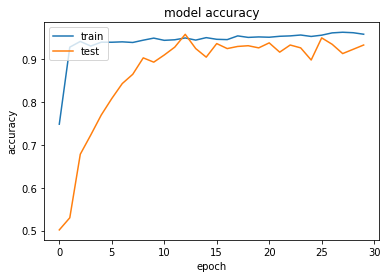

In [19]:
plt.plot(training_model.history['acc'])
plt.plot(training_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left') 
plt.show()


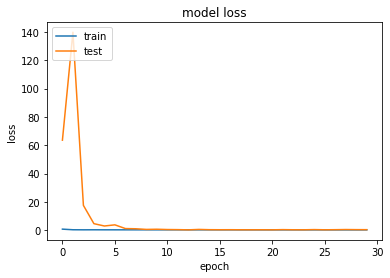

In [20]:
# summarize history for loss plt.plot(history.history['loss']) plt.plot(history.history['val_loss']) plt.title('model loss')
plt.plot(training_model.history['loss'])
plt.plot(training_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left') 
plt.show()

In [21]:
dependencies = {'mcc':mcc, 'ppv':ppv, 'tpr':tpr}
best_model = load_model("model.h5", custom_objects=dependencies)

In [23]:
x_test, y_test = generate_training_data(test_data, neg_ratio=10, max_dist=40, grid_resolution=4)
x_test = x_test.todense()

100%|██████████| 300/300 [00:16<00:00, 17.86it/s]


confusion matrix
[[0.919      0.081     ]
 [0.03666667 0.96333333]]


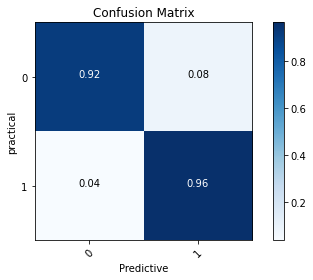

In [24]:
y_pred = best_model.predict(x_test)
y_pred = np.piecewise(y_pred, [y_pred < 0.5, y_pred >= 0.5], [0., 1.])
cnf_matrix = confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0, 1], normalize=True,
                      title='Confusion Matrix')

# Output 

In [49]:
test_prediction = []
for pro_idx in trange(824):
    raw_testing_data = {
    'pro': [],
    'lig': []
    }
    for lig_idx in range(824):
        raw_testing_data['pro'].append(read_test_pdb("testing_data_release/testing_data/{:04d}_pro_cg.pdb".format(pro_idx + 1)))
        raw_testing_data['lig'].append(read_test_pdb("testing_data_release/testing_data/{:04d}_lig_cg.pdb".format(lig_idx + 1)))
    x_test, y_test = generate_training_data(raw_testing_data, neg_ratio=0, max_dist=40, grid_resolution=4, quiet = True)
    x_test = x_test.todense()
    results = best_model.predict(x_test)
    ranks = np.argpartition(-results.flatten(), 10)[:10]
    test_prediction.append(ranks)

100%|██████████| 824/824 [1:17:39<00:00,  5.65s/it]


In [60]:
df.columns = [ 'lig1_id', 'lig2_id','lig3_id','lig4_id','lig5_id','lig6_id','lig7_id','lig8_id','lig9_id','lig10_id']
df['pro_id']=range(1,825)
df=df.set_index('pro_id')

In [62]:
df.reset_index()

,pro_id,lig1_id,lig2_id,lig3_id,lig4_id,lig5_id,lig6_id,lig7_id,lig8_id,lig9_id,lig10_id
0,1,88,18,345,208,131,741,374,241,796,720
1,2,330,11,683,491,589,458,478,635,456,134
2,3,306,52,440,82,222,761,624,397,754,283
3,4,474,133,404,281,580,343,278,53,708,686
4,5,755,596,641,146,553,743,568,129,482,324
...,...,...,...,...,...,...,...,...,...,...,...
819,820,308,576,291,171,689,473,646,2,110,230
820,821,477,742,406,71,438,710,572,741,561,180
821,822,392,520,210,381,326,172,600,342,3,252
822,823,636,300,512,569,91,563,179,205,109,80


In [ ]:
df.to_csv('‘test_predictions.txt')